In [ ]:
import numpy as np
import pandas as pd
import re,os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor



In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/EDA"
CSV_PATH = os.path.join(BASE_DIR, "storia_real_estate_dataset_3.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("CSV_PATH:", CSV_PATH)
print("OUTPUT_DIR:", OUTPUT_DIR)

def savefig(name):
    path = os.path.join(OUTPUT_DIR, name)
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("Saved figure:", path)

Mounted at /content/drive
CSV_PATH: /content/drive/MyDrive/EDA/storia_real_estate_dataset_3.csv
OUTPUT_DIR: /content/drive/MyDrive/EDA/outputs


In [ ]:
df = pd.read_csv(CSV_PATH)
print("Initial shape:", df.shape)

Initial shape: (645, 10)


In [ ]:
def clean_numeric(value):
    #Extract numeric value from messy strings like '123.000 €' or '45,5 m²'. "N/A"
    if pd.isna(value) or value == "N/A":
        return np.nan
    s = str(value).strip()
    s = s.replace(",", ".")
    s = re.sub(r"[^\d.]", "", s)
    return float(s) if s else np.nan

def extract_sector(loc):
    """
    Hybrid sector extraction:
    1) If the text contains explicit numeric sector info (Sector 1..6 / Sectorul 2 etc.), return 'Sector X'
    2) Else fallback to directional/area keywords (Centru/Nord/Sud/Est/Vest)
    3) Else return 'Other' or 'Unknown'
    """

    if pd.isna(loc):
        return "Unknown"

    s = str(loc).strip().lower()

    # Numeric sector extraction (robust regex)
    # Matches: "sector 1", "sectorul 2", "sector  3", "Sector 4", etc.

    m = re.search(r"\bsector(?:ul)?\s*(\d+)\b", s)
    if m:
        return f"Sector {m.group(1)}"

    # Optional: sometimes written with punctuation like "sector-1" or "sector: 1"

    m2 = re.search(r"\bsector(?:ul)?\s*[-:]\s*(\d+)\b", s)
    if m2:
        return f"Sector {m2.group(1)}"

    # Directional fallback / Add a few common variants to be safer
    if any(k in s for k in ["centru", "central"]):
        return "Centru"
    if any(k in s for k in ["nord", "northern"]):
        return "Nord"
    if any(k in s for k in ["sud", "southern"]):
        return "Sud"
    if any(k in s for k in ["est", "eastern"]):
        return "Est"
    if any(k in s for k in ["vest", "western"]):
        return "Vest"

    # If none matched
    return "Other"

In [ ]:
def sector_id_from_sector_label(sector_label):
    # 'Sector 4' -> 4 else nan
    if pd.isna(sector_label):
        return np.nan
    s = str(sector_label)
    m = re.match(r"^Sector\s+(\d+)$", s)
    return float(m.group(1)) if m else np.nan

In [ ]:
df["Price"] = df["Price_Raw"].apply(clean_numeric)
df["Area_m2"] = df["Area_m2"].apply(clean_numeric)
df["Room_Number"] = df["Room_Number"].apply(clean_numeric)
df["Sector"] = df["Location_Info"].apply(extract_sector)

# Optional safety: remove rows where key fields are missing or invalid
df = df.dropna(subset=["Price", "Area_m2", "Room_Number"])
df = df[df["Room_Number"] > 0]
df = df[(df["Price"] > 0) & (df["Area_m2"] > 0)]

df_before = df.copy()

In [ ]:
print("Before filtering:", df.shape)

# Filtering (keep your logic)
df_filtered = df[(df["Area_m2"] >= 20) & (df["Area_m2"] <= 350)].copy()
price_threshold = df_filtered["Price"].quantile(0.95)
df_filtered = df_filtered[df_filtered["Price"] < price_threshold].copy()

print("After filtering:", df_filtered.shape)
print("Price 95th percentile threshold used:", price_threshold)

print("\nRows per sector AFTER filtering:")
print(df_filtered["Sector"].value_counts(dropna=False))

print("\nDropped rows per sector (before - after):")
print(
    (df_before["Sector"].value_counts(dropna=False) - df_filtered["Sector"].value_counts(dropna=False))
    .fillna(0).astype(int)
)

df = df_filtered.copy()

# Save filtered dataset snapshot
filtered_path = os.path.join(OUTPUT_DIR, "dataset_filtered_snapshot.csv")
df.to_csv(filtered_path, index=False)
print("Saved dataset snapshot:", filtered_path)

Before filtering: (635, 11)
After filtering: (600, 11)
Price 95th percentile threshold used: 372204.99999999965

Rows per sector AFTER filtering:
Sector
Sector 4    217
Sector 3    153
Sector 2     76
Sector 1     57
Sector 6     56
Sector 5     21
Unknown      20
Name: count, dtype: int64

Dropped rows per sector (before - after):
Sector
Sector 4     2
Sector 3     5
Sector 2    11
Sector 1    16
Sector 6     1
Sector 5     0
Unknown      0
Name: count, dtype: int64
Saved dataset snapshot: /content/drive/MyDrive/EDA/outputs/dataset_filtered_snapshot.csv


In [ ]:
df["Area_per_Room"] = df["Area_m2"] / df["Room_Number"]
df["Area_x_Rooms"] = df["Area_m2"] * df["Room_Number"]

# Sector numeric ID + Zone category
df["Sector_ID"] = df["Sector"].apply(sector_id_from_sector_label)

# Zone label: if numeric sector -> "NumericSector" else keep sector label (Centru/Nord/etc.)
df["Sector_Zone"] = np.where(df["Sector"].str.startswith("Sector "), "NumericSector", df["Sector"])

Saved figure: /content/drive/MyDrive/EDA/outputs/Price_distribution.png


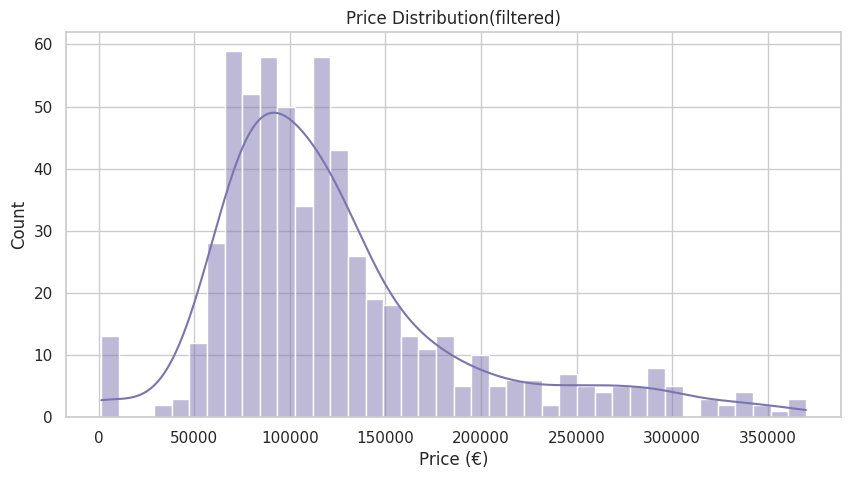

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,5))
sns.histplot(df["Price"], bins=40, kde=True, color="#7C74B0")
plt.title("Price Distribution(filtered)")
plt.xlabel("Price (€)")
savefig("Price_distribution.png")
plt.show()

Saved figure: /content/drive/MyDrive/EDA/outputs/Logprice_distribution.png


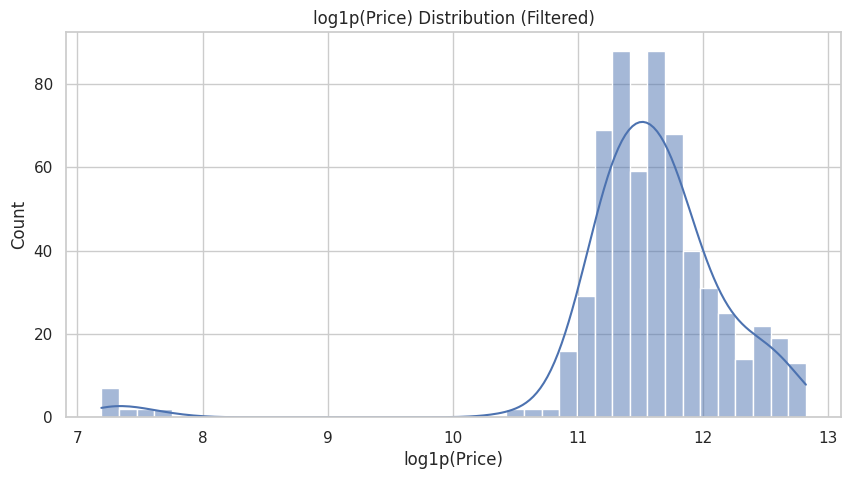

In [ ]:
df["LogPrice"] = np.log1p(df["Price"])
plt.figure(figsize=(10,5))
sns.histplot(df["LogPrice"], bins=40, kde=True)
plt.title("log1p(Price) Distribution (Filtered)")
plt.xlabel("log1p(Price)")
savefig("Logprice_distribution.png")
plt.show()

Saved figure: /content/drive/MyDrive/EDA/outputs/Price_vs_area_per_room.png


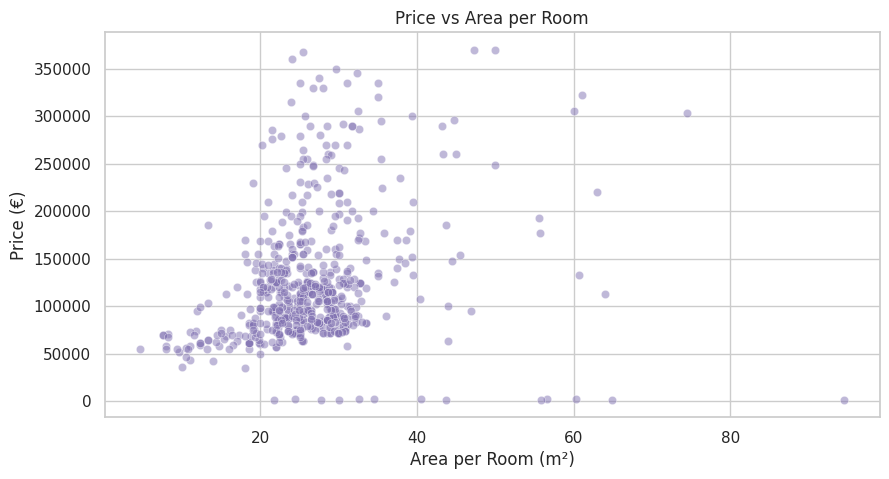

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x="Area_per_Room", y="Price", alpha=0.5, color="#8172B2")
plt.title("Price vs Area per Room")
plt.xlabel("Area per Room (m²)")
plt.ylabel("Price (€)")
savefig("Price_vs_area_per_room.png")
plt.show()

Saved figure: /content/drive/MyDrive/EDA/outputs/Logprice_vs_area_per_room.png


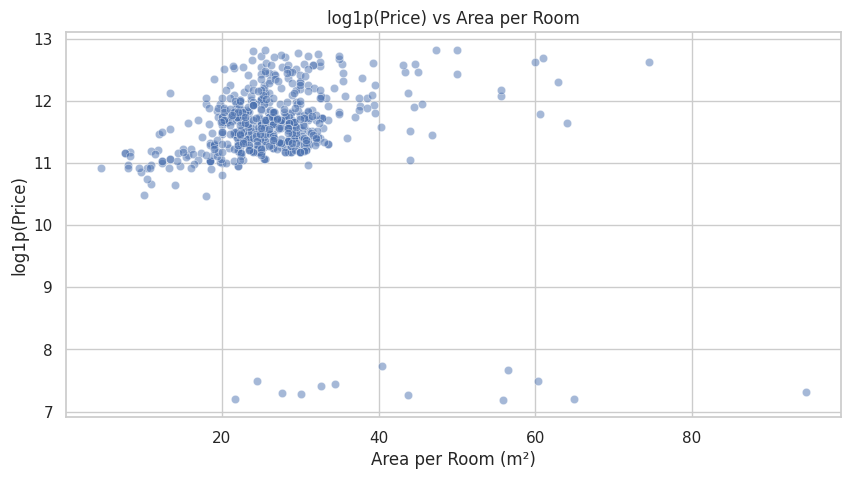

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x="Area_per_Room", y="LogPrice", alpha=0.5)
plt.title("log1p(Price) vs Area per Room")
plt.xlabel("Area per Room (m²)")
plt.ylabel("log1p(Price)")
savefig("Logprice_vs_area_per_room.png")
plt.show()

/tmp/ipython-input-1050091456.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Sector", y="Price", palette="Set2")


Saved figure: /content/drive/MyDrive/EDA/outputs/Price_by_sector.png


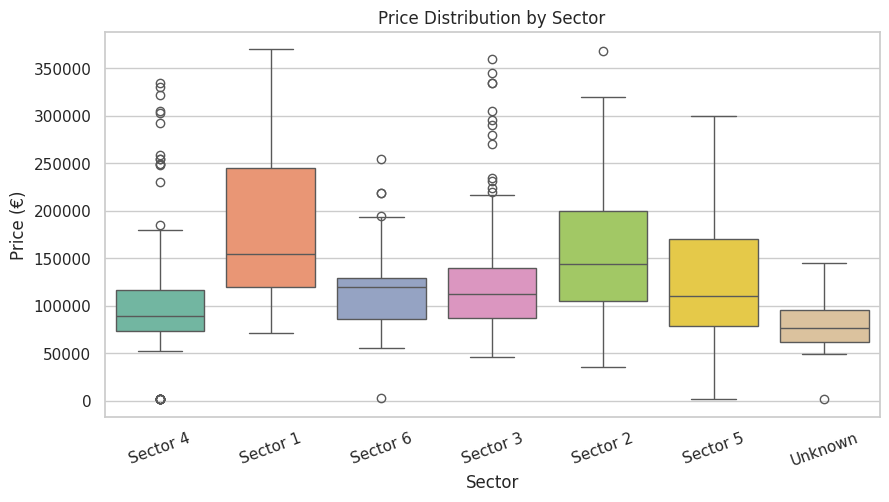

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="Sector", y="Price", palette="Set2")
plt.title("Price Distribution by Sector")
plt.xlabel("Sector")
plt.ylabel("Price (€)")
plt.xticks(rotation=20)
savefig("Price_by_sector.png")
plt.show()

Saved figure: /content/drive/MyDrive/EDA/outputs/Price_vs_area_by_sector.png


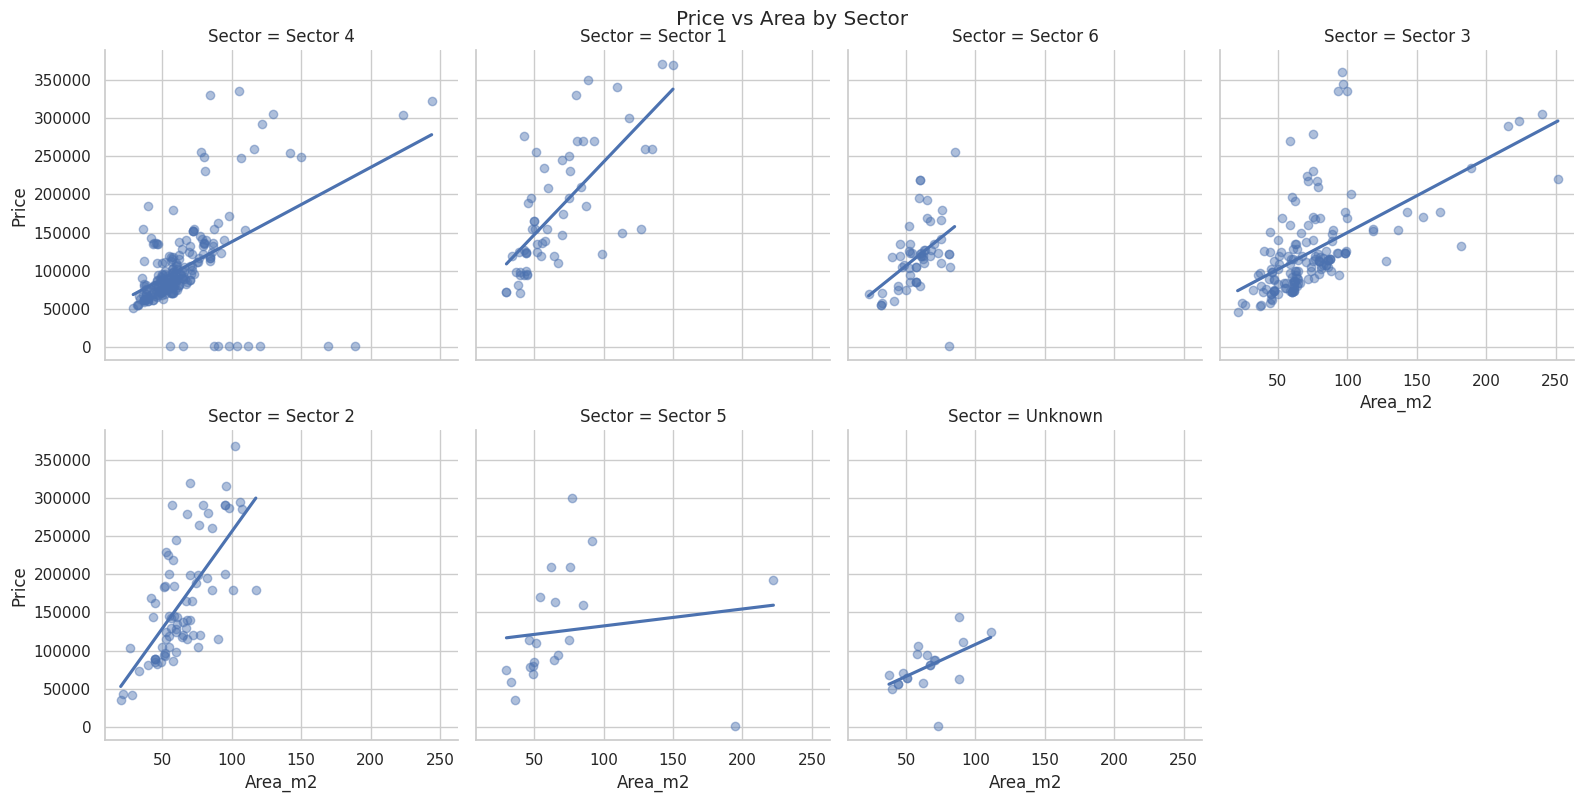

In [ ]:
g = sns.lmplot(
    data=df,
    x="Area_m2",
    y="Price",
    col="Sector",
    col_wrap=4,
    height=4,
    scatter_kws={"alpha": 0.45},
    ci=None,
    palette="Set2"
)
plt.suptitle("Price vs Area by Sector", y=1.00)
plt.savefig(os.path.join(OUTPUT_DIR, "Price_vs_area_by_sector.png"), dpi=200, bbox_inches="tight")
print("Saved figure:", os.path.join(OUTPUT_DIR, "Price_vs_area_by_sector.png"))
plt.show()


In [ ]:
# Base numeric features
X_num = df[["Area_m2", "Room_Number", "Area_per_Room", "Area_x_Rooms", "Sector_ID"]].copy()
X_num["Sector_ID"] = X_num["Sector_ID"].fillna(0)  # 0 => "no numeric sector"

# Zone one-hot (Centru/Nord/.../Other/Unknown/NumericSector)
X_zone = pd.get_dummies(df["Sector_Zone"], prefix="Zone", drop_first=True)

# We'll still do Target Encoding, but ONLY using training fold (no leakage)
y = df["Price"].copy()

# Split
X_base = pd.concat([X_num, X_zone, df[["Sector"]]], axis=1)  # keep Sector for TE mapping only
X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)

X_train = X_train.copy()
X_test = X_test.copy()

# Target Encoding (Sector_TE)
sector_means = y_train.groupby(X_train["Sector"]).mean()
global_mean = y_train.mean()

X_train["Sector_TE"] = X_train["Sector"].map(sector_means).fillna(global_mean)
X_test["Sector_TE"]  = X_test["Sector"].map(sector_means).fillna(global_mean)

# Final matrices (drop raw Sector text)
X_train_final = X_train.drop(columns=["Sector"])
X_test_final  = X_test.drop(columns=["Sector"])

In [ ]:
models = {
    "Linear (scaled)": Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())]),
    "Ridge (scaled)": Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0))]),
    "Lasso (scaled)": Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(alpha=0.001, max_iter=5000))]),
    "Decision Tree": DecisionTreeRegressor(
        max_depth=8,
        min_samples_leaf=8,
        random_state=42
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=400, max_depth=14, min_samples_leaf=4,
        random_state=42, n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}

In [ ]:
def eval_holdout_raw(model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    mae = mean_absolute_error(yte, pred)
    rmse = np.sqrt(mean_squared_error(yte, pred))
    r2 = r2_score(yte, pred)
    return mae, rmse, r2

def eval_holdout_log(model, Xtr, ytr, Xte, yte):
    # train on log1p(y), predict log, invert back to euros for metrics
    ytr_log = np.log1p(ytr)
    yte_log = np.log1p(yte)

    model.fit(Xtr, ytr_log)
    pred_log = model.predict(Xte)

    pred_eur = np.expm1(pred_log)  # back-transform
    pred_eur = np.maximum(pred_eur, 0)  # safety

    # Metrics in EURO space (what we care about)
    mae_eur = mean_absolute_error(yte, pred_eur)
    rmse_eur = np.sqrt(mean_squared_error(yte, pred_eur))
    r2_eur = r2_score(yte, pred_eur)

    # Also keep R2 in log-space (optional but useful for report)
    r2_log = r2_score(yte_log, pred_log)

    return mae_eur, rmse_eur, r2_eur, r2_log, pred_eur

HOLDOUT RESULTS (RAW Price)
               Model           MAE          RMSE        R2
0    Linear (scaled)  37462.850995  53193.196211  0.388697
1     Lasso (scaled)  37462.851920  53193.197132  0.388697
2     Ridge (scaled)  37503.387278  53263.842808  0.387072
3      Random Forest  39037.324821  55257.277804  0.340335
4  Gradient Boosting  39510.415829  56265.570639  0.316041
5      Decision Tree  39439.047407  57679.501634  0.281234
Saved: /content/drive/MyDrive/EDA/outputs/Holdout_results_RAW_numeric.csv
Saved figure: /content/drive/MyDrive/EDA/outputs/Holdout_r2_raw.png


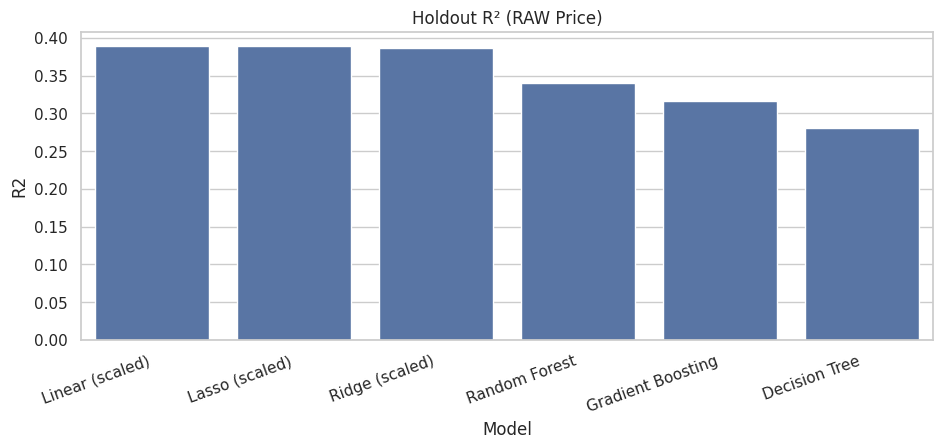

In [ ]:
raw_rows = []
for name, model in models.items():
    mae, rmse, r2 = eval_holdout_raw(model, X_train_final, y_train, X_test_final, y_test)
    raw_rows.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

raw_df = pd.DataFrame(raw_rows).sort_values("R2", ascending=False).reset_index(drop=True)
print("HOLDOUT RESULTS (RAW Price)")
print(raw_df)

raw_path = os.path.join(OUTPUT_DIR, "Holdout_results_RAW_numeric.csv")
raw_df.to_csv(raw_path, index=False)
print("Saved:", raw_path)

plt.figure(figsize=(11,4))
sns.barplot(x="Model", y="R2", data=raw_df)
plt.title("Holdout R² (RAW Price)")
plt.xticks(rotation=20, ha="right")
savefig("Holdout_r2_raw.png")
plt.show()

HOLDOUT RESULTS (LOG1P Price, evaluated back in EUR)
               Model       MAE_EUR      RMSE_EUR    R2_EUR  R2_LOG_SPACE
0      Random Forest  38621.762227  56334.113237  0.314374      0.213825
1  Gradient Boosting  39767.484175  56909.269513  0.300302     -0.010521
2    Linear (scaled)  41644.700746  61949.957187  0.170862      0.198026
3     Lasso (scaled)  41712.076108  62166.368181  0.165059      0.196571
4     Ridge (scaled)  41849.481955  62560.684190  0.154434      0.196406
5      Decision Tree  44308.830406  63356.427825  0.132787      0.047586
Saved: /content/drive/MyDrive/EDA/outputs/Holdout_results_LOG_numeric.csv
Saved figure: /content/drive/MyDrive/EDA/outputs/Holdout_r2_log_trained_eval_eur.png


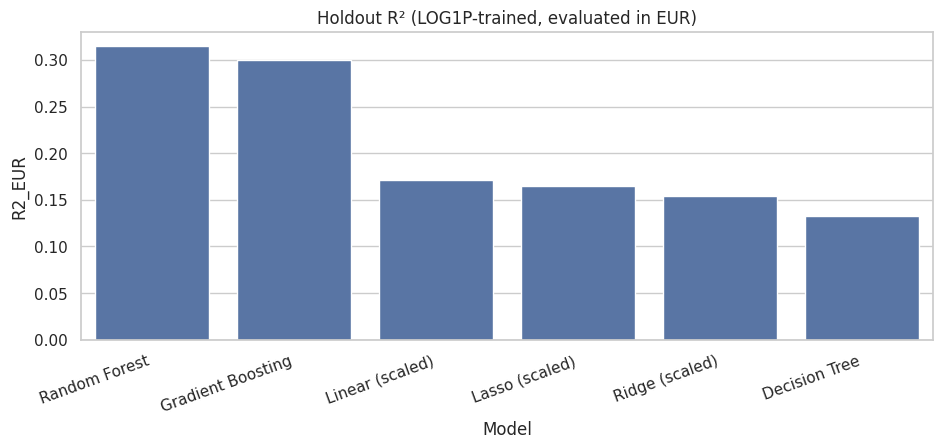

In [ ]:
log_rows = []
log_preds_store = {}

for name, model in models.items():
    mae_eur, rmse_eur, r2_eur, r2_log, pred_eur = eval_holdout_log(
        model, X_train_final, y_train, X_test_final, y_test
    )

    log_rows.append({
        "Model": name,
        "MAE_EUR": mae_eur,
        "RMSE_EUR": rmse_eur,
        "R2_EUR": r2_eur,
        "R2_LOG_SPACE": r2_log
    })

    log_preds_store[name] = pred_eur

log_df = pd.DataFrame(log_rows).sort_values("R2_EUR", ascending=False).reset_index(drop=True)
print("HOLDOUT RESULTS (LOG1P Price, evaluated back in EUR)")
print(log_df)

log_path = os.path.join(OUTPUT_DIR, "Holdout_results_LOG_numeric.csv")
log_df.to_csv(log_path, index=False)
print("Saved:", log_path)

plt.figure(figsize=(11,4))
sns.barplot(x="Model", y="R2_EUR", data=log_df)
plt.title("Holdout R² (LOG1P-trained, evaluated in EUR)")
plt.xticks(rotation=20, ha="right")
savefig("Holdout_r2_log_trained_eval_eur.png")
plt.show()


In [ ]:
best_log_model_name = log_df.iloc[0]["Model"]
best_log_pred_eur = log_preds_store[best_log_model_name]
y_true = y_test.values

residuals = best_log_pred_eur - y_true

Saved figure: /content/drive/MyDrive/EDA/outputs/Residuals_vs_true_price_best_log_model.png


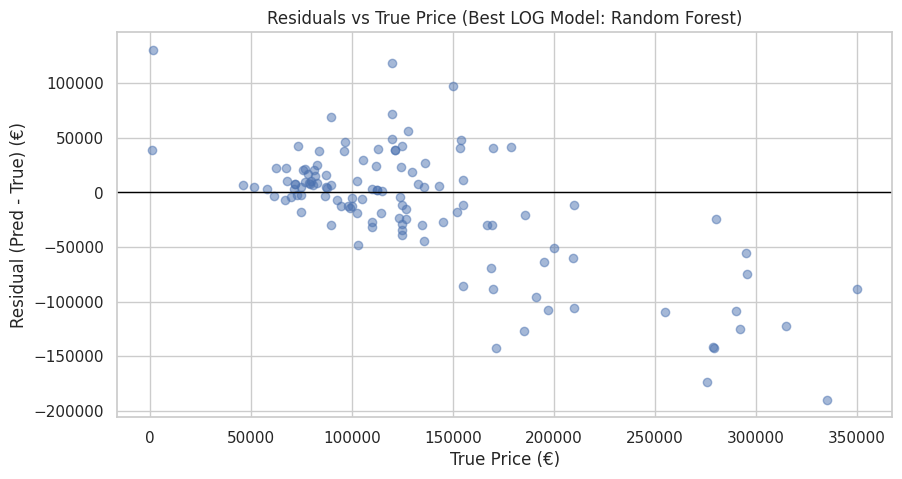

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_true, residuals, alpha=0.5)
plt.axhline(0, color="black", linewidth=1)
plt.title(f"Residuals vs True Price (Best LOG Model: {best_log_model_name})")
plt.xlabel("True Price (€)")
plt.ylabel("Residual (Pred - True) (€)")
savefig("Residuals_vs_true_price_best_log_model.png")
plt.show()

Saved figure: /content/drive/MyDrive/EDA/outputs/Residual_distribution_best_log_model.png


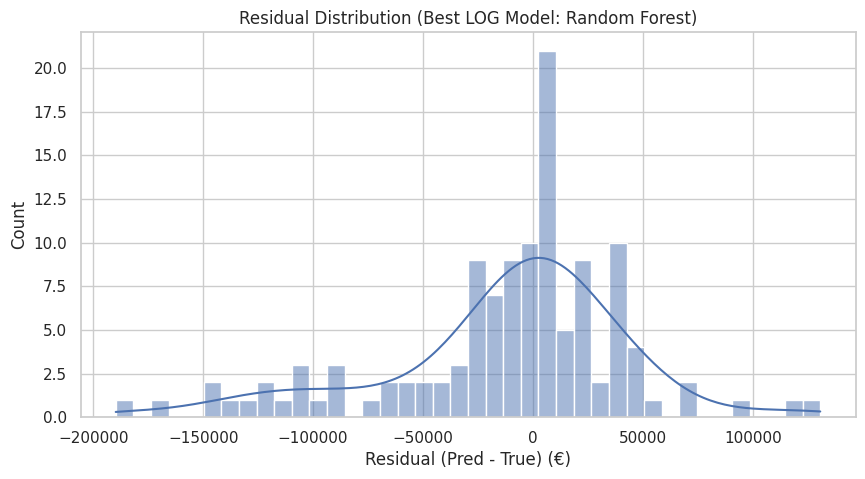

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=40, kde=True)
plt.title(f"Residual Distribution (Best LOG Model: {best_log_model_name})")
plt.xlabel("Residual (Pred - True) (€)")
savefig("Residual_distribution_best_log_model.png")
plt.show()

In [ ]:
best_model = models[best_log_model_name]
y_train_log = np.log1p(y_train)

cv_scores = cross_val_score(
    best_model,
    X_train_final,
    y_train_log,
    cv=5,
    scoring="r2"
)

print(f"\n[CV R2 - TRAIN ONLY | LOG TARGET] {best_log_model_name}")
print("Mean:", round(cv_scores.mean(), 4))
print("Std :", round(cv_scores.std(), 4))

cv_path = os.path.join(OUTPUT_DIR, f"cv_r2_log_target_{best_log_model_name.replace(' ', '_')}.csv")
pd.DataFrame({"cv_r2_log_target": cv_scores}).to_csv(cv_path, index=False)
print("Saved:", cv_path)


[CV R2 - TRAIN ONLY | LOG TARGET] Random Forest
Mean: 0.0612
Std : 0.2376
Saved: /content/drive/MyDrive/EDA/outputs/cv_r2_log_target_Random_Forest.csv


In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
grid = GridSearchCV(rf, param_grid, scoring="r2", cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_final, np.log1p(y_train))  # tune on log target

print("\n[GridSearchRF | LOG TARGET] Best params:", grid.best_params_)
print("[GridSearchRF | LOG TARGET] Best CV R2:", round(grid.best_score_, 4))

cv_results_df = pd.DataFrame(grid.cv_results_).sort_values("mean_test_score", ascending=False)
grid_results_path = os.path.join(OUTPUT_DIR, "gridsearch_rf_logtarget_cv_results.csv")
cv_results_df.to_csv(grid_results_path, index=False)
print("Saved:", grid_results_path)

summary_path = os.path.join(OUTPUT_DIR, "gridsearch_rf_logtarget_best_summary.txt")
with open(summary_path, "w", encoding="utf-8") as f:
    f.write("RandomForest GridSearchCV Summary (LOG target)\n")
    f.write(f"Best Params: {grid.best_params_}\n")
    f.write(f"Best CV R2 (log-space): {grid.best_score_:.6f}\n")
print("Saved:", summary_path)

# Evaluate tuned RF in EUR on holdout
best_rf = grid.best_estimator_
mae_eur, rmse_eur, r2_eur, r2_log, pred_eur = eval_holdout_log(best_rf, X_train_final, y_train, X_test_final, y_test)

tuned_row = pd.DataFrame([{
    "Model": "Random Forest (tuned, log-target)",
    "MAE_EUR": mae_eur,
    "RMSE_EUR": rmse_eur,
    "R2_EUR": r2_eur,
    "R2_LOG_SPACE": r2_log
}])

Fitting 5 folds for each of 24 candidates, totalling 120 fits

[GridSearchRF | LOG TARGET] Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
[GridSearchRF | LOG TARGET] Best CV R2: 0.1102
Saved: /content/drive/MyDrive/EDA/outputs/gridsearch_rf_logtarget_cv_results.csv
Saved: /content/drive/MyDrive/EDA/outputs/gridsearch_rf_logtarget_best_summary.txt


Saved: /content/drive/MyDrive/EDA/outputs/holdout_results_LOG_with_tuned_RF.csv
Saved figure: /content/drive/MyDrive/EDA/outputs/Holdout_r2_log_with_tuned_rf.png


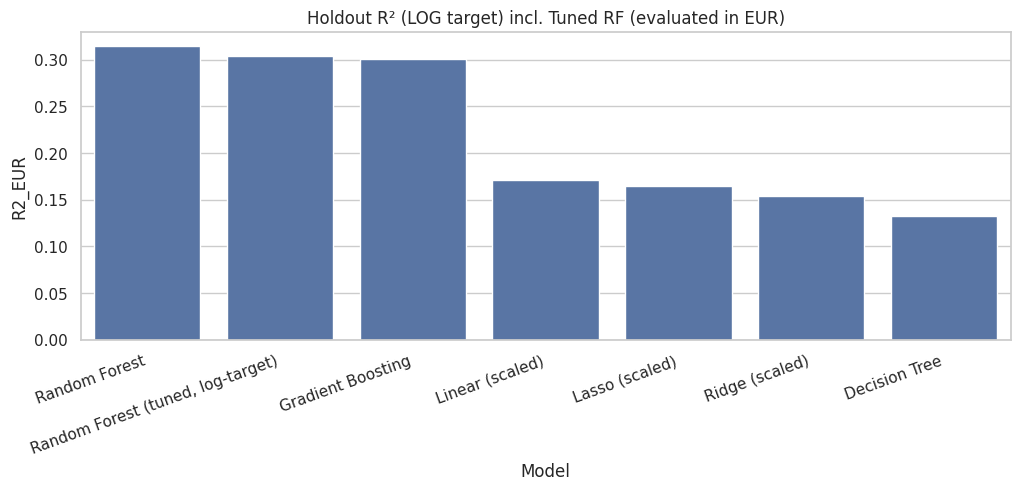

In [ ]:
log_df_plus = pd.concat([log_df, tuned_row], ignore_index=True).sort_values("R2_EUR", ascending=False)
log_plus_path = os.path.join(OUTPUT_DIR, "holdout_results_LOG_with_tuned_RF.csv")
log_df_plus.to_csv(log_plus_path, index=False)
print("Saved:", log_plus_path)

plt.figure(figsize=(12,4))
sns.barplot(x="Model", y="R2_EUR", data=log_df_plus)
plt.title("Holdout R² (LOG target) incl. Tuned RF (evaluated in EUR)")
plt.xticks(rotation=20, ha="right")
savefig("Holdout_r2_log_with_tuned_rf.png")
plt.show()

In [ ]:
print("Done. All outputs saved under:", OUTPUT_DIR)

Done. All outputs saved under: /content/drive/MyDrive/EDA/outputs
